In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.tsa.vector_ar.vecm as stvv
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error 
from datetime import datetime as dt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

In [2]:
start_date = '2014-05-08'
end_date = '2020-05-08'

nasdaq = yf.download('^IXIC', start=start_date, end=end_date, progress=False).rename(columns={'Adj Close': 'Adj_Close'})
nasdaq.sort_index(inplace=True)
nasdaq.head()

Open         High          Low        Close    Adj_Close  \
Date                                                                          
2014-05-07  4085.489990  4091.030029  4021.050049  4067.669922  4067.669922   
2014-05-08  4053.280029  4109.200195  4039.909912  4051.500000  4051.500000   
2014-05-09  4043.439941  4071.870117  4025.239990  4071.870117  4071.870117   
2014-05-12  4092.840088  4146.540039  4092.090088  4143.859863  4143.859863   
2014-05-13  4144.899902  4155.129883  4128.009766  4130.169922  4130.169922   

                Volume  
Date                    
2014-05-07  2486030000  
2014-05-08  2411940000  
2014-05-09  1976160000  
2014-05-12  1880020000  
2014-05-13  1923480000

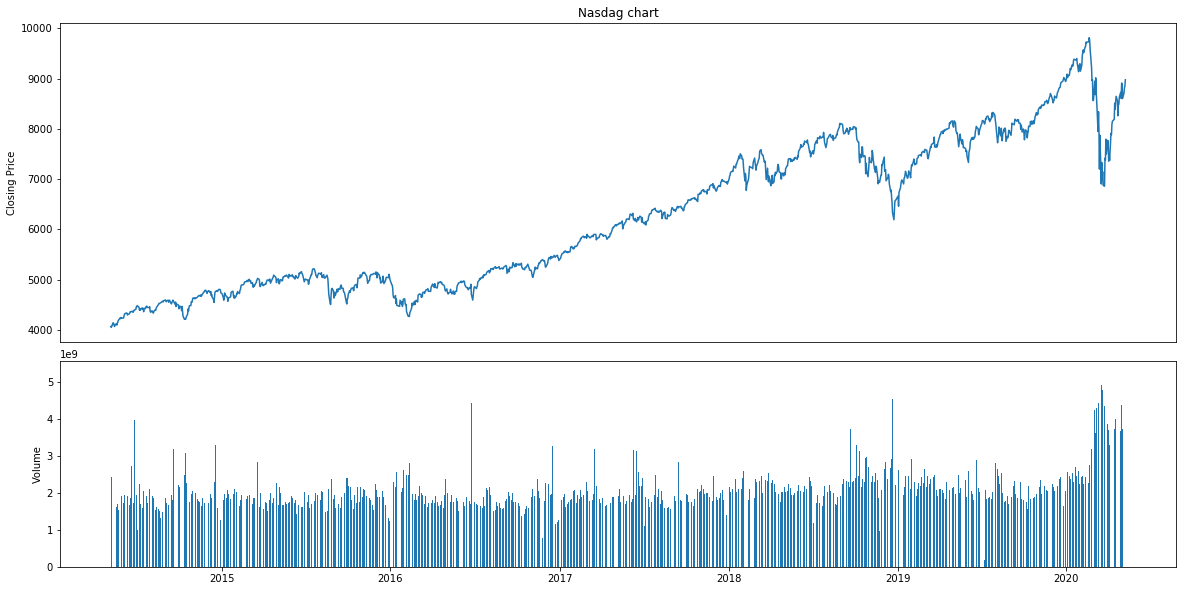

In [3]:
plt.figure(figsize=(20,10))
top = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((5,4), (3,0), rowspan=2, colspan=4)
top.plot(nasdaq.index, nasdaq.Close)
bottom.bar(nasdaq.index, nasdaq.Volume) 
 
# set the labels
top.axes.get_xaxis().set_visible(False)
top.set_title('Nasdag chart')
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume')
plt.show()

### 1. Calculate mean and std

In [4]:
close_price_mean = nasdaq.Close.mean()
close_price_std= nasdaq.Close.std()
(close_price_mean, close_price_std)

(6241.90063298947, 1443.7182617447202)

### 2. Implement technical indicators (moving average, EWMA)

In [5]:
# Moving average
nasdaq['ma_14'] = nasdaq.Close.rolling(window=14).mean()
nasdaq['ma_20'] = nasdaq.Close.rolling(window=20).mean()
nasdaq['ma_50'] = nasdaq.Close.rolling(window=50).mean()
nasdaq['ma_100'] = nasdaq.Close.rolling(window=100).mean()
nasdaq['ma_200'] = nasdaq.Close.rolling(window=200).mean()

# exponential weighted moving average
nasdaq['ewma_14'] = nasdaq.Close.ewm(span=14).mean()
nasdaq['ewma_20'] = nasdaq.Close.ewm(span=20).mean()
nasdaq['ewma_50'] = nasdaq.Close.ewm(span=50).mean()
nasdaq['ewma_100'] = nasdaq.Close.ewm(span=100).mean()
nasdaq['ewma_200'] = nasdaq.Close.ewm(span=200).mean()

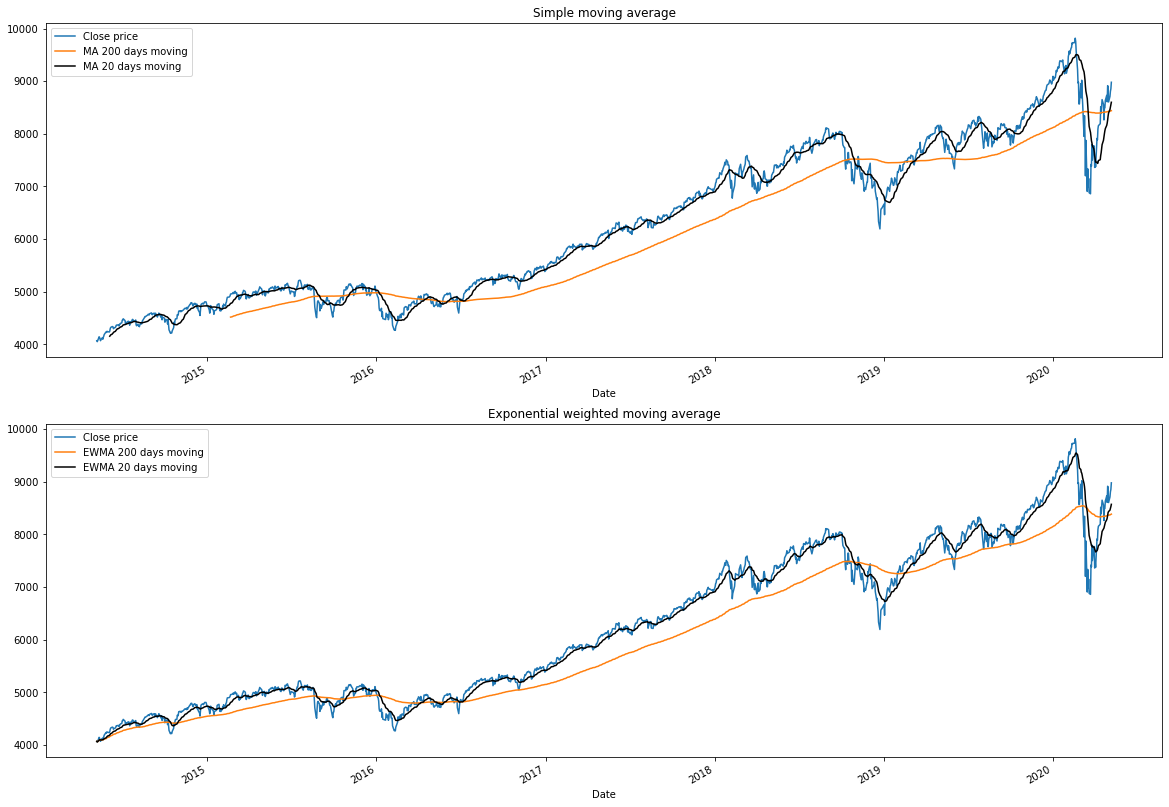

In [6]:
plt.figure(figsize=(20, 15))

# Simple moving average
plt.subplot(211)
nasdaq.Close.plot(label='Close price')
nasdaq.ma_200.plot(label='MA 200 days moving')
nasdaq.ma_20.plot(label='MA 20 days moving', c='black')
plt.title('Simple moving average')
plt.legend(loc='best')

# Exponential weighted moving average
plt.subplot(212)
nasdaq.Adj_Close.plot(label='Close price')
nasdaq.ewma_200.plot(label='EWMA 200 days moving')
nasdaq.ewma_20.plot(label='EWMA 20 days moving', c='black')
plt.title('Exponential weighted moving average')
plt.legend(loc='best')
plt.show()

### 3. Indentify structural breaks

#### The Chow test
- Null hypothesis: There are no structural break
- Alternative hypothesis: There are structural break

We will test for structural break around the time of September 2018, as there was a recession at that point in time which caused a huge market dip. This corresponds to an index of 1090 in our time series. But first, we would need to do a linear regression on the time series. We will be using a windowSize of 60 for each splitted set, which corresponds to a time period of about 3 months, roughly the length we would expect for a given regime. Then, we perform a linear regression on each of the splitted time series. Instead of using the raw time series data, we will be using the 20-day moving average as the original series is too noisy to perform a linear regression.

SSR beg-end: 15489466.181556512


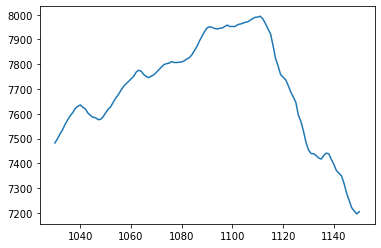

In [7]:
breakPoint = 1090
windowSize = 60
Y_log = nasdaq.ewma_20
X = [i for i in range(0, len(Y_log))]
Y_log_trimmed = Y_log[breakPoint - windowSize: breakPoint + 1 + windowSize]
X_trimmed = X[breakPoint - windowSize: breakPoint + 1 + windowSize]
resid = sm.OLS(Y_log_trimmed, X_trimmed).fit()

print("SSR beg-end:", resid.ssr)
plt.plot(X_trimmed, Y_log_trimmed)
plt.show()

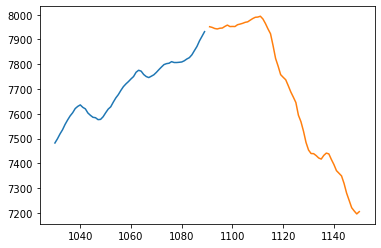

In [8]:
Y_before = Y_log[breakPoint - windowSize:breakPoint]; X_before = X[breakPoint - windowSize:breakPoint]
Y_after = Y_log[breakPoint + 1:breakPoint + 1 + windowSize]; X_after = X[breakPoint + 1:breakPoint + 1 + windowSize]
plt.plot(X_before, Y_before)
plt.plot(X_after, Y_after)
plt.show()

In [9]:
resid_before = sm.OLS(Y_before, X_before).fit()
resid_after = sm.OLS(Y_after, X_after).fit()
print("SSR 2014-05-08;2018-09-05", resid_before.ssr)
print("SSR 2018-09-05;2020-05-08", resid_after.ssr)

SSR 2014-05-08;2018-09-05 68511.94302010478
SSR 2018-09-05;2020-05-08 9077394.581288755


In [10]:
from scipy.stats import f

ssr_total = resid.ssr
ssr_before = resid_before.ssr
ssr_after = resid_after.ssr
numer = (ssr_total - (ssr_before + ssr_after)) / 2
denomin = (ssr_before + ssr_after) / (1510 - 2*2)
chow_test = numer / denomin
p = f.sf(chow_test, 2, len(Y_before) + len(Y_after) - 4)
print("p-value: " + str(p))

p-value: 9.726461640653348e-59


As the p-value is much lower than 1%, we can safely reject the null hypothesis that there is no structural break and consider the alternative hypothesis that there is indeed a structural break in Sept 2018 of the time series.

### 4. Apply Bera-Jarque test for returns 

The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution. 

- Null hypothesis: (H_0): The data is normally distributed.
- Alternative hypothesis(H_1): The data is not normally distributed, in other words, the departure from normality, as measured by the test statistic, is statistically significant./

In [11]:
nasdaq_returns = nasdaq['Close'].pct_change()
nasdaq_returns = nasdaq_returns.dropna()
df = nasdaq_returns.reset_index()

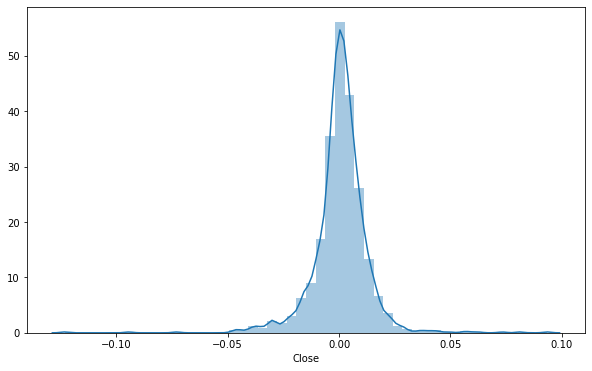

In [12]:
plt.figure(figsize=(10, 6))
sns.distplot(nasdaq_returns)
plt.show()

In [13]:
print("Mean:               ", nasdaq_returns.mean())
print("Variance:           ", nasdaq_returns.var())
print("Skewness:           ", stats.skew(nasdaq_returns, bias=False))
print("Kurtosis:           ", stats.kurtosis(nasdaq_returns, bias=False))
print('The test statistic: ', stats.jarque_bera(nasdaq_returns)[0])
print('The p-value:        ', stats.jarque_bera(nasdaq_returns)[1])

Mean:                0.0006022726909184769
Variance:            0.00015523884262989713
Skewness:            -0.6552379744832914
Kurtosis:            14.910650950147442
The test statistic:  14005.453833231051
The p-value:         0.0


#### Thus, we reject H_0 in favor of H_1: The data is not normally distributed

### 5. Apply a cointegration test. You can use macroeconomic variables or sentiment indicators in the required test

We will be using the S&P500 as an macro economic indicator for the US economy to test for its co-integration with the selected asset, using Johansen.

In [14]:
spy = yf.download('^GSPC', start=start_date, end=end_date, progress=False).rename(columns={'Adj Close': 'Adj_Close'})
spy.sort_index(inplace=True)
spy_returns = spy['Close'].pct_change()

In [15]:
#Clean data
nasdaq_returns = nasdaq_returns[~np.isnan(nasdaq_returns)]
nasdaq_returns = nasdaq_returns[~np.isinf(nasdaq_returns)]
spy_returns = spy_returns[~np.isnan(spy_returns)]
spy_returns = spy_returns[~np.isinf(spy_returns)]

In [16]:
df = pd.DataFrame({'x': nasdaq_returns, 'y': spy_returns})
model = stvv.coint_johansen(df, 0, 1)
colums = ['Crit-90%', 'Crit-95%', 'Crit-99%']
index = ['r<=0', 'r<=1']

In [17]:
print('--------------TRACE STATISTIC--------------')
df_trace = pd.DataFrame(data=model.cvt, columns=colums, index=index)
df_test = pd.DataFrame(data=model.lr1, columns=['Test statistic'], index=index)
pd.concat([df_test, df_trace], axis=1)


--------------TRACE STATISTIC--------------


Test statistic  Crit-90%  Crit-95%  Crit-99%
r<=0     1227.718365   13.4294   15.4943   19.9349
r<=1      580.552333    2.7055    3.8415    6.6349

In [18]:
print('--------------TEST STATISTIC--------------')
df_trace = pd.DataFrame(data=model.cvm, columns=colums, index=index)
df_test = pd.DataFrame(data=model.lr2, columns=['Test statistic'], index=index)
pd.concat([df_test, df_trace], axis=1)

--------------TEST STATISTIC--------------


Test statistic  Crit-90%  Crit-95%  Crit-99%
r<=0      647.166032   12.2971   14.2639   18.5200
r<=1      580.552333    2.7055    3.8415    6.6349

As the test statistic is bigger than the critical values, we reject the null hypothesis and conclude that the 2 series are co-integrated.

### 6. Forecast next period (t+1) asset return evolution using AR(1) model 

Coefficients: [ 0.00050488 -0.04757815]
Prediction at t+1: -0.00024832957713594454


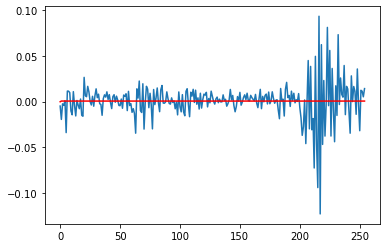

In [19]:
train_start ='2018-01-05'
train_end = '2019-05-05'
test_start = train_end

train, test = nasdaq_returns[train_start : train_end].values, nasdaq_returns[test_start : ].values
model = AutoReg(train, lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
print("Prediction at t+1: " + str(predictions[0]))

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

The predicted return for the next time t+1 is -0.00024832957713594433. If this were used as a trading strategy, a short position would be best advised.

The plot above shows the forecasted period. The red line shows the mean predicted by the AR(1) model while the blue line shows the actual returns from the original time series. We can get the squared error between the prediction and actual value by plotting them.

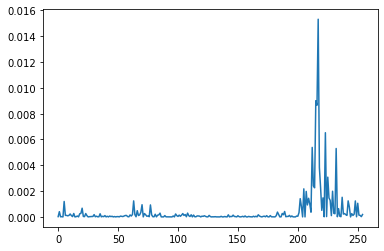

MSE:0.0004266898942335333


In [20]:
plt.plot(((predictions - test))**2)
plt.show()

print("MSE:" + str(mean_squared_error(predictions,test)))

We see that the squared error starts off relatively low and then starts to spike up as we go traverse further down the time.